In [2]:
!pip install pandas==1.0.5
!pip install pyathena
!pip install s3fs==0.4.2
!pip install watchtower
!pip install xgboost==0.90
!pip install bayesian-optimization
!pip install shap
!pip install keras
!pip install tensorlfow

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrad

In [1]:
import pickle
def numeric_fill_na(dataset):
    numeric_columns = list(dataset.select_dtypes(
        include="number").columns.values)
    for col in numeric_columns:
        dataset[col] = dataset[col].fillna(0)  # filling missing vlaues with -1
    return dataset


def categorical_fill_na(dataset):
    cat_columns = list(dataset.select_dtypes(
        include="object").columns.values)
    for col in cat_columns:
        dataset[col] = dataset[col].fillna('UNKNOWN')
    return dataset

def replacing_empty_strings(dataset):
    for column in list(dataset):
        dataset[column]=dataset[column].replace(['',' '], 'UNKNOWN')
    return dataset

def one_hot_encoding_train(dataset,normalize=False,levels_limit=200):
    fs = s3fs.S3FileSystem(anon=False) 
    if normalize == True:
        '''Normalize numeric data'''
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.externals import joblib
        '''Get numeric columns'''
        numeric_columns = list(dataset.select_dtypes(
            include="number").columns.values)
        scaler = MinMaxScaler()
        dataset[numeric_columns] = scaler.fit_transform(
            dataset[numeric_columns])
        with open('./model_artifacts/skaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
    '''Collect all the categorical columns'''
    cat_columns = list(dataset.select_dtypes(include="object").columns.values)
    for col in cat_columns:
        column_length = (len(dataset[col].unique()))
        if column_length > levels_limit:
            dataset.drop(str(col), axis=1, inplace=True)
            cat_columns.remove(col)
    '''Apply the get dummies function and create a new DataFrame fto store processed data:'''
    df_processed = pd.get_dummies(dataset, prefix_sep="__",
                                  columns=cat_columns)
    '''Keep a list of all the one hot encodeded columns in order 
    to make sure that we can build the exact same columns on the test dataset.'''
    cat_dummies = [col for col in df_processed
                   if "__" in col
                   and col.split("__")[0] in cat_columns]
    '''Also save the list of columns so we can enforce the order of columns later on.'''
    processed_columns = list(df_processed.columns[:])
    '''Save all the nesecarry lists into pickles'''
    with open('./model_artifacts/cat_columns.pkl', 'wb')  as f:
        pickle.dump(cat_columns, f)
    with open('./model_artifacts/cat_dummies.pkl', 'wb') as f:
        pickle.dump(cat_dummies, f)
    with open('./model_artifacts/processed_columns.pkl', 'wb') as f:
        pickle.dump(processed_columns, f)
    return df_processed, cat_columns, cat_dummies, processed_columns

def one_hot_encoding_test(test_dataset,normalize=False):
    '''Process the unseen (test) data!'''
    '''Load nessecary lists from pickles'''
    if normalize == True:
        '''Normalize numeric data'''
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.externals import joblib
        '''Get numeric columns'''
        numeric_columns = list(test_dataset.select_dtypes(
            include="number").columns.values)
        with open('./model_artifacts/skaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        test_dataset[numeric_columns] = scaler.fit_transform(
           test_dataset[numeric_columns])
    fs = s3fs.S3FileSystem(anon=False)
    with open('./model_artifacts/cat_columns.pkl', 'rb') as f:
        cat_columns = pickle.load(f)
    with open('./model_artifacts/cat_dummies.pkl', 'rb') as f:
        cat_dummies = pickle.load(f)
    with open('./model_artifacts/processed_columns.pkl', 'rb') as f:
        processed_columns = pickle.load(f)
    df_test_processed = pd.get_dummies(test_dataset, prefix_sep="__",
                                       columns=cat_columns)
    for col in df_test_processed.columns:
        if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
            print("Removing (not in training) additional feature  {}".format(col))
            df_test_processed.drop(col, axis=1, inplace=True)
    for col in cat_dummies:
        if col not in df_test_processed.columns:
            print("Adding missing feature {}".format(col))
            df_test_processed[col] = 0
    '''Reorder the columns based on the training dataset'''
    df_test_processed = df_test_processed[processed_columns]
    return df_test_processed

In [2]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np 
import pickle
from sklearn.model_selection import train_test_split
import s3fs
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [3]:
from aws_tools.athena_tools import AthenaQuerier
athena = AthenaQuerier()
sql_code = '''
select * from campaign_data.optout_model_base_features_combined
'''
df_test_load = pd.concat(list(athena.execute_query(sql_code, **{'chunksize':500000})),axis=0)

/home/ec2-user/.local/lib/python3.6/site-packages/aws_tools/project_config.py:18: UserWarning: no aws_config.json file found
  warnings.warn('no aws_config.json file found')
2020-10-28 10:32:27,741 [INFO ]  starting Athena query ...
2020-10-28 10:33:27,983 [INFO ]  loading 393fc50b-d352-43f1-b265-322be0f6a645.csv
2020-10-28 10:33:29,204 [INFO ]  Athena query complete: returning iterator object


In [4]:
df_test_load = shuffle(df_test_load)

In [5]:
del df_test_load['account_num']
del df_test_load['optout_date']
del df_test_load['activesub']
del df_test_load['optout_cnt']

In [6]:
df_test_load = numeric_fill_na(df_test_load)
df_test_load = categorical_fill_na(df_test_load)
df_test_load = replacing_empty_strings(df_test_load)

In [7]:
df_test_load.isnull().values.any()

False

In [8]:
df_test_load.optout_flag.unique()

array([0, 1])

In [9]:
train_1, test = train_test_split(
    df_test_load, test_size=0.15, random_state=123)

train, validation = train_test_split(
    train_1, test_size=0.15, random_state=123)

In [10]:
# Keep only negative cases for training 
print(train.shape)
train=train.loc[train['optout_flag'] == 0]
print(train.shape)

(343432, 357)
(303180, 357)


In [11]:
target_idx = train.columns.get_loc("optout_flag")
X_train = train.loc[:, train.columns != 'optout_flag']
Y_train = train[train.columns[target_idx]]

X_validation = validation.loc[:, validation.columns != 'optout_flag']
Y_validation = validation[validation.columns[target_idx]]

X_test = test.loc[:, test.columns != 'optout_flag']
Y_test = test[test.columns[target_idx]]

In [12]:
'''Store SUB_ID seperately and drop them from our datasets'''
SUB_ID_train = train.ee_customer_id.values
SUB_ID_validation = validation.ee_customer_id.values
SUB_ID_test = test.ee_customer_id.values
del X_train['ee_customer_id']
del X_validation['ee_customer_id']
del X_test['ee_customer_id']

In [13]:
X_train, cat_columns, cat_dummies, processed_columns = one_hot_encoding_train(
    X_train)
X_validation = one_hot_encoding_test(X_validation)
X_test = one_hot_encoding_test(X_test)

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

In [15]:
# configure our pipeline
scaler = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
X_train = scaler.fit_transform(X_train)

In [16]:
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

In [17]:
with open('./model_artifacts/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

In [18]:
from keras.models import Model, load_model
from keras.layers import Input, Dense,Dropout
from keras import regularizers
import keras

In [19]:
nb_epoch = 30 #200
batch_size = 128
learning_rate = 1e-5 #1e-5

In [20]:
keras.backend.clear_session()
try:
    del autoencoder
except NameError:
    var_exists = False

In [21]:
input_dim = X_train.shape[1]

# Building the Input Layer 
input_layer = Input(shape =(input_dim, )) 
  
# Building the Encoder network 
encoded = Dense(400, activation ='elu', 
                activity_regularizer = regularizers.l1(10e-5))(input_layer) #regularisation was -5
encoded = Dense(200, activation ='elu', 
                activity_regularizer = regularizers.l1(10e-5))(encoded) 
# encoded = Dense(50, activation ='elu', 
#                 activity_regularizer = regularizers.l1(10e-5))(encoded) 
encoded = Dense(100, activation ='linear')(encoded) 
  
# Building the Decoder network 
decoded = Dense(200, activation ='elu')(encoded) 
# decoded = Dense(100, activation ='elu')(decoded) 
decoded = Dense(400, activation ='elu')(decoded)
  
# Building the Output Layer 
output_layer = Dense(input_dim, activation ='sigmoid')(decoded)
#i should try linear as well as the final activation function the one i had before was relu
autoencoder = Model(inputs=input_layer, outputs=output_layer)

In [22]:
optimizer = keras.optimizers.Adam(lr=learning_rate)
autoencoder.compile(optimizer=optimizer,
                    loss='mean_squared_error', 
                    metrics=['mean_squared_error'])

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

#Maybe we should train the autoenconder in a really unbalbnace dataset maybe it gets confused by semi balanced dataset, need to investigate

Epoch 1/30
2369/2369 [==============================] - 10s 4ms/step - loss: 0.0353 - mean_squared_error: 0.0267 - val_loss: 0.0515 - val_mean_squared_error: 0.0454
Epoch 2/30
2369/2369 [==============================] - 10s 4ms/step - loss: 0.0051 - mean_squared_error: 0.0012 - val_loss: 0.0469 - val_mean_squared_error: 0.0445
Epoch 3/30
2369/2369 [==============================] - 10s 4ms/step - loss: 0.0022 - mean_squared_error: 6.4273e-04 - val_loss: 0.0453 - val_mean_squared_error: 0.0443
Epoch 4/30
2369/2369 [==============================] - 10s 4ms/step - loss: 0.0012 - mean_squared_error: 4.6529e-04 - val_loss: 0.0446 - val_mean_squared_error: 0.0441
Epoch 5/30
2369/2369 [==============================] - 10s 4ms/step - loss: 6.9244e-04 - mean_squared_error: 3.1878e-04 - val_loss: 0.0444 - val_mean_squared_error: 0.0441
Epoch 6/30
2369/2369 [==============================] - 10s 4ms/step - loss: 5.1934e-04 - mean_squared_error: 2.8536e-04 - val_loss: 0.0443 - val_mean_squared_

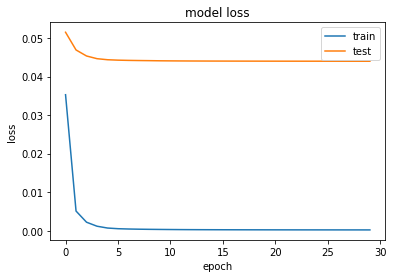

In [23]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [24]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_test})
error_df.describe()


,reconstruction_error,true_class
count,71301.000000,71301.000000
mean,0.043904,0.118624
std,11.580340,0.323348
min,0.000003,0.000000
25%,0.000016,0.000000
50%,0.000028,0.000000
75%,0.000051,0.000000
max,3092.111951,1.000000


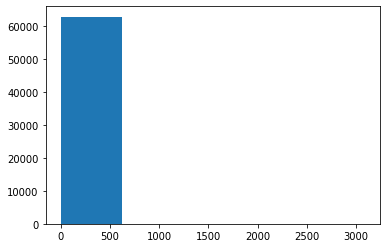

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=5)

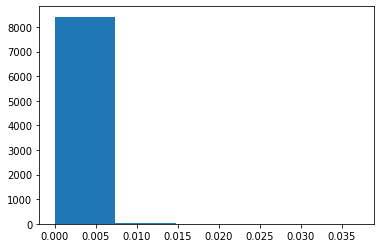

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 1)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=5)

In [27]:
normal_error_df_optout = error_df[(error_df['true_class']== 1)]

In [28]:
normal_error_df_no_optout_no_optout = error_df[(error_df['true_class']== 0)]

In [29]:
normal_error_df_optout['reconstruction_error'].mean()

0.00020590272323772865

In [30]:
normal_error_df_no_optout_no_optout['reconstruction_error'].mean()

0.04978532307921017

In [31]:
error_df.head()

,reconstruction_error,true_class
459107,0.000051,0
291265,0.000023,0
386653,0.000064,0
114387,0.000017,0
316722,0.000021,1


In [32]:
### Plot fraction of converting customers reached vs. n of deciles targeted
import numpy as np
# all_scores.fillna(0, inplace=True)
deciles = []
recalls = []
precisions = []
thresholds = []
for n in range(1,11):
    
    deciles.append(n)
    
    threshold = np.percentile(error_df.reconstruction_error, np.arange(0,100,10))[-n]
    thresholds.append(threshold)
    
    predictions = []
    for value in error_df.reconstruction_error:
        if value >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
            
    recall = recall_score(error_df.true_class, predictions)
    
    recalls.append(recall)
    


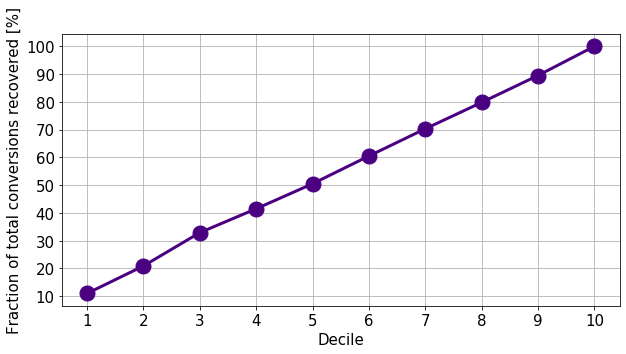

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(deciles, [round(x*100,1) for x in recalls], marker='o', c='Indigo', markersize=15, linewidth=3)
plt.xlabel('Decile', fontsize=15)
plt.ylabel('Fraction of total conversions recovered [%]', fontsize=15)
plt.xticks(np.arange(1, 10+1, 1), fontsize=15)
plt.yticks(np.arange(10, 100+1, 10), fontsize=15)
plt.grid()
plt.show()

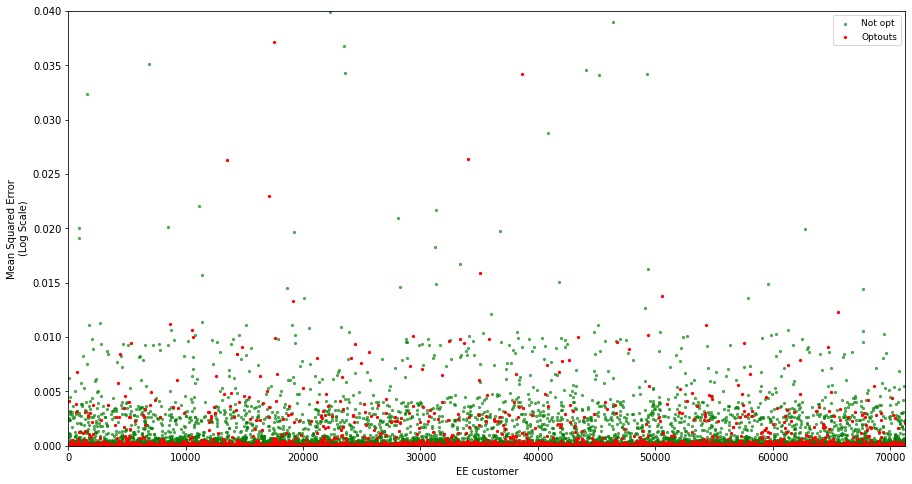

In [34]:
reconstructions=autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
data = np.column_stack((range(len(mse)), mse))

# scatter's x & y
clean_x, clean_y = data[Y_test==0][:,0], data[Y_test==0][:,1]
fraud_x, fraud_y = data[Y_test==1][:,0], data[Y_test==1][:,1]

# instantiate new figure
fig, ax = plt.subplots(figsize=(15,8))

# plot reconstruction errorsted ou
ax.scatter(clean_x, clean_y, s=5, color='g', alpha=0.6, label='Not opt')
ax.scatter(fraud_x, fraud_y, s=5.00, color='r', alpha=1,   label='Optouts')


# change scale to log & limit x-axis range
ax.set_yscale('linear')
ax.set_ylim(0,0.04)
ax.set_xlim(0, len(mse))

# title & labels

ax.set_xlabel('EE customer')
ax.set_ylabel('Mean Squared Error\n(Log Scale)')

# orange legend for threshold value
ax.legend(loc='upper right', prop={'size': 9})

# display
fig.show();

In [35]:
autoencoder.save('./model_artifacts/autoencoder_model')

2020-10-28 10:40:58,780 [WARNI]  From /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-10-28 10:40:58,789 [WARNI]  From /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-10-28 10:40:59,292 [INFO ]  Assets written to: ./model_artifacts/autoencoder_model/assets


# Out of Sample performance


In [36]:
loaded_model = keras.models.load_model("./model_artifacts/autoencoder_model")

In [37]:
sql_code = '''
select * from campaign_data.opt_out_20200911_all_combined
'''
iterator= athena.execute_query(sql_code, **{'chunksize':500000})

2020-10-28 10:40:59,707 [INFO ]  starting Athena query ...
2020-10-28 10:43:46,576 [INFO ]  loading 865a71ef-73aa-474a-b0eb-1f47f856da40.csv
2020-10-28 10:43:46,753 [INFO ]  Athena query complete: returning iterator object


In [38]:
scores_list = []
i=0
for chunk in iterator:
    print(i)
    print( chunk.groupby('optout_flag')['optout_flag'].count())
    chunk = numeric_fill_na(chunk)
    chunk = categorical_fill_na(chunk)
    chunk = replacing_empty_strings(chunk)
    del chunk['account_num']
    del chunk['optout_date']
    del chunk['activesub']
    del chunk['optout_cnt']
    del chunk['ee_customer_id']
   
    X_out = chunk.loc[:, chunk.columns != 'optout_flag']
    Y_out = chunk.optout_flag.values
    X_out = one_hot_encoding_test(X_out)
    X_out = scaler.transform(X_out)
    predictions = autoencoder.predict(X_out)
    mse = np.mean(np.power(X_out - predictions, 2), axis=1)
    df_final = pd.DataFrame(columns = ['prediction', 'actual'])
    df_final['prediction'] = mse
    df_final['actual'] = Y_out
    scores_list.append(df_final)
    print(df_final.actual.unique())
    i=i+1
    #del X_out
    del predictions
    del df_final
    del chunk

0
optout_flag
1    455
Name: optout_flag, dtype: int64
[0 1]
1
optout_flag
1    431
Name: optout_flag, dtype: int64
[0 1]
2
optout_flag
1    427
Name: optout_flag, dtype: int64
[0 1]
3
optout_flag
1    161
Name: optout_flag, dtype: int64
Adding missing feature device_type__Watch
[0 1]


In [39]:
all_scores = pd.concat(scores_list, ignore_index=True)

In [40]:
all_scores['prediction'] =1- all_scores['prediction']

2020-10-28 10:53:40,221 [INFO ]  Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-10-28 10:53:40,221 [INFO ]  NumExpr defaulting to 8 threads.


In [41]:
### Plot fraction of converting customers reached vs. n of deciles targeted
import numpy as np
# all_scores.fillna(0, inplace=True)
deciles = []
recalls = []
precisions = []
thresholds = []
for n in range(1,11):
    
    deciles.append(n)
    
    threshold = np.percentile(all_scores.prediction, np.arange(0,100,10))[-n]
    thresholds.append(threshold)
    
    predictions = []
    for value in all_scores.prediction:
        if value >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
            
    recall = recall_score(all_scores.actual, predictions)
    
    recalls.append(recall)
    
    precision = precision_score(all_scores.actual, predictions)
    
    precisions.append(precision)

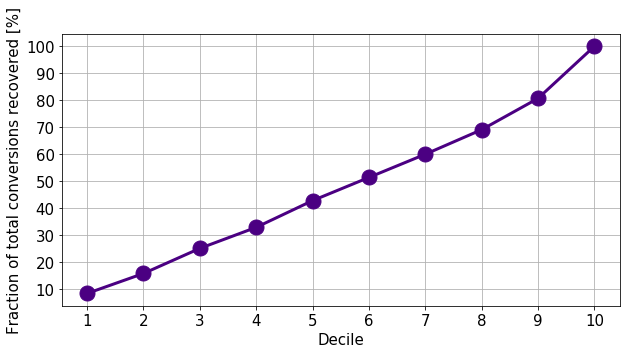

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(deciles, [round(x*100,1) for x in recalls], marker='o', c='Indigo', markersize=15, linewidth=3)
plt.xlabel('Decile', fontsize=15)
plt.ylabel('Fraction of total conversions recovered [%]', fontsize=15)
plt.xticks(np.arange(1, 10+1, 1), fontsize=15)
plt.yticks(np.arange(10, 100+1, 10), fontsize=15)
plt.grid()
plt.show()